In [1]:
# Dataset: WLASL (Word-Level American Sign Language Dataset)
# Source: https://github.com/dxli94/WLASL
# Authors: Dongxu Li, Cristian Rodriguez, Xin Yu, and Hongdong Li
# Citation: "Word-Level Deep Sign Language Recognition from Video: A New Large-Scale Dataset and Methods Comparison" - BMVC 2020

In [1]:
import os
import sys
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, f1_score, mean_squared_error, accuracy_score, classification_report

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.is_available()

True

In [3]:
def transfer_label_to_tensor(labels):
    # Get the list of glosses
    gloss_list = labels['label'].tolist()

    # Create gloss-to-index mapping
    unique_glosses = sorted(set(gloss_list))
    gloss_to_index = {gloss: idx for idx, gloss in enumerate(unique_glosses)}
    print(gloss_to_index)

    # Convert labels to integers
    label_indices = [gloss_to_index[gloss] for gloss in gloss_list]
    label_tensor = torch.tensor(label_indices, dtype=torch.long)

    return label_tensor

In [4]:
train_labels = pd.read_csv(r"D:\Courses\Pattern Recognition\UB-CSE-555\data_preprocess\dataset\train\labels_train.csv")
test_labels = pd.read_csv(r"D:\Courses\Pattern Recognition\UB-CSE-555\data_preprocess\dataset\test\labels_test.csv")

top50_glosses = train_labels['label'].value_counts().nlargest(100).index.tolist()

train_mask = train_labels['label'].isin(top50_glosses)
test_mask = test_labels['label'].isin(top50_glosses)

train_labels = train_labels[train_mask].reset_index(drop=True)
test_labels = test_labels[test_mask].reset_index(drop=True)

le = LabelEncoder()
le.fit(top50_glosses)
train_labels_tensor = torch.tensor(le.transform(train_labels['label']), dtype=torch.long)
test_labels_tensor = torch.tensor(le.transform(test_labels['label']), dtype=torch.long)

train_data = np.load(r"D:\Courses\Pattern Recognition\UB-CSE-555\data_preprocess\dataset\train\videos_train.npy", allow_pickle=True)
test_data = np.load(r"D:\Courses\Pattern Recognition\UB-CSE-555\data_preprocess\dataset\test\videos_test.npy", allow_pickle=True)

train_data = train_data[train_mask.to_numpy()]
test_data = test_data[test_mask.to_numpy()]

# Step 6: Reshape
train_tensor = torch.tensor(train_data, dtype=torch.float32).squeeze(-1).permute(0, 2, 1, 3).reshape(-1, 64, 134)
test_tensor = torch.tensor(test_data, dtype=torch.float32).squeeze(-1).permute(0, 2, 1, 3).reshape(-1, 64, 134)

print("train_tensor shape:", train_tensor.shape)
print("train_labels_tensor shape:", train_labels_tensor.shape)

# Step 7: Dataloaders
train_dataset = TensorDataset(train_tensor, train_labels_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(test_tensor, test_labels_tensor)
test_loader = DataLoader(test_dataset, batch_size=32)

num_classes = 100

train_tensor shape: torch.Size([1780, 64, 134])
train_labels_tensor shape: torch.Size([1780])


In [5]:
class CNN_BiLSTM_Classifier(nn.Module):
    def __init__(self, input_dim, cnn_output_dim, lstm_hidden_num, lstm_layer, class_num):
        super().__init__()

        # CNN layer
        # self.cnn = nn.Sequential(
        #     nn.Conv1d(input_dim, 256, kernel_size=3, padding=1),
        #     nn.BatchNorm1d(256),
        #     nn.ReLU(),
        #     nn.Conv1d(256, cnn_output_dim, kernel_size=3, padding=1),
        #     nn.BatchNorm1d(cnn_output_dim),
        #     nn.ReLU(),
        #     nn.Dropout(0.3)
        # )
        self.cnn = nn.Sequential(
            nn.Conv1d(input_dim, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Conv1d(256, 192, kernel_size=3, padding=1),
            nn.BatchNorm1d(192),
            nn.ReLU(),
            nn.Conv1d(192, cnn_output_dim, kernel_size=3, padding=1),
            nn.BatchNorm1d(cnn_output_dim),
            nn.ReLU(),
            nn.Dropout(0.3)
        )


        # LSTM layer
        self.lstm = nn.LSTM(
            input_size=cnn_output_dim,
            hidden_size=lstm_hidden_num,
            num_layers=lstm_layer,
            bidirectional=True,
            batch_first=True
        )

        self.classifier = nn.Sequential(
            nn.Linear(lstm_hidden_num * 2, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, class_num)
        )

    '''
    D: input feature dimension (flatten 3D key points)
    B: batch size
    T: number of time steps
    C: CNN output channels
    H: LSTM hidden size
    '''
    def forward(self, x):
        x = x.transpose(1, 2) # [B,T,D] -> [B,D,T]
        x = self.cnn(x) # [B,D,T] -> [B,C,T]
        x = x.transpose(1, 2) # [B,C,T] -> [B,T,C]

        # frame_output: [B,T,2*H]; hn: [lstm_layer,B,H]
        frame_output, (hn, cn) = self.lstm(x)
        last_hidden = torch.cat([hn[-2], hn[-1]], dim=1)

        output = self.classifier(last_hidden)
        
        return output


In [6]:
train_tensor.shape

torch.Size([1780, 64, 134])

In [7]:
test_tensor.shape

torch.Size([258, 64, 134])

In [26]:
num_epochs = 100000
train_acc, val_acc, test_acc = [], [], []
train_loss, val_loss, test_loss = [], [], []
all_preds = []
all_labels = []

# model = KeypointLSTM(input_dim=134, hidden=128, num_classes=num_classes).to(device)
model = CNN_BiLSTM_Classifier(
    input_dim=134,
    cnn_output_dim=128,
    lstm_hidden_num=128,
    lstm_layer=1,
    class_num=num_classes
).to(device)


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
best_model = 0

def test_model(loader, accuracy, losses):
    model.eval()
    correct, samples = 0, 0
    total_loss = 0.0
    with torch.no_grad():
        for matrices, labels in loader:
            labels = labels.to(device)
            matrices = matrices.to(device)

            output = model(matrices)
            loss = criterion(output, labels)
            total_loss += loss.item()
            _, pred = torch.max(output, 1)
            samples += labels.size(0)
            correct += (pred == labels).sum().item()
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
        acc = 100 * correct / samples
        accuracy.append(acc)
        losses.append(total_loss / len(loader))

for epoch in range(num_epochs):
    model.train()
    train_correct, train_samples = 0, 0
    total_loss = 0.0

    for matrices, labels in tqdm(train_loader, desc=f"Epoch {epoch}"):
        matrices, labels = matrices.to(device), labels.to(device)

        output = model(matrices)
        loss = criterion(output, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, pred = torch.max(output, 1)
        train_correct += (pred == labels).sum().item()
        train_samples += labels.size(0)
        total_loss += loss.item()

    acc = 100 * train_correct / train_samples
    train_acc.append(acc)
    train_loss.append(total_loss / len(train_loader))

    test_model(test_loader, test_acc, test_loss)
    if test_acc[-1] > best_model:
        best_model = test_acc[-1]
        torch.save(model.state_dict(), "best_model.pth")


    if epoch % 100 == 0:
        print(f"Epoch {epoch}")
        print(f"Train Accuracy: {train_acc[-1]:.2f}%")
        print(f"Test Accuracy: {test_acc[-1]:.2f}%")

Epoch 0: 100%|██████████| 56/56 [00:00<00:00, 97.59it/s] 


Epoch 0
Train Accuracy: 2.13%
Test Accuracy: 2.33%


Epoch 100: 100%|██████████| 56/56 [00:00<00:00, 164.66it/s]


Epoch 100
Train Accuracy: 87.58%
Test Accuracy: 21.71%


Epoch 200: 100%|██████████| 56/56 [00:00<00:00, 167.79it/s]


Epoch 200
Train Accuracy: 95.62%
Test Accuracy: 20.16%


Epoch 300: 100%|██████████| 56/56 [00:00<00:00, 172.53it/s]


Epoch 300
Train Accuracy: 95.90%
Test Accuracy: 21.71%


Epoch 400: 100%|██████████| 56/56 [00:00<00:00, 178.40it/s]


Epoch 400
Train Accuracy: 96.69%
Test Accuracy: 24.81%


Epoch 500: 100%|██████████| 56/56 [00:00<00:00, 180.81it/s]


Epoch 500
Train Accuracy: 97.19%
Test Accuracy: 21.32%


Epoch 600: 100%|██████████| 56/56 [00:00<00:00, 180.20it/s]


Epoch 600
Train Accuracy: 97.87%
Test Accuracy: 22.48%


Epoch 700: 100%|██████████| 56/56 [00:00<00:00, 180.08it/s]


Epoch 700
Train Accuracy: 96.57%
Test Accuracy: 18.60%


Epoch 800: 100%|██████████| 56/56 [00:00<00:00, 179.19it/s]


Epoch 800
Train Accuracy: 98.48%
Test Accuracy: 21.32%


Epoch 900: 100%|██████████| 56/56 [00:00<00:00, 177.27it/s]


Epoch 900
Train Accuracy: 98.20%
Test Accuracy: 24.81%


Epoch 1000: 100%|██████████| 56/56 [00:00<00:00, 177.13it/s]


Epoch 1000
Train Accuracy: 98.71%
Test Accuracy: 24.42%


Epoch 1100: 100%|██████████| 56/56 [00:00<00:00, 178.01it/s]


Epoch 1100
Train Accuracy: 98.60%
Test Accuracy: 25.58%


Epoch 1200: 100%|██████████| 56/56 [00:00<00:00, 179.78it/s]


Epoch 1200
Train Accuracy: 97.87%
Test Accuracy: 22.87%


Epoch 1300: 100%|██████████| 56/56 [00:00<00:00, 177.96it/s]


Epoch 1300
Train Accuracy: 99.27%
Test Accuracy: 24.03%


Epoch 1400: 100%|██████████| 56/56 [00:00<00:00, 177.92it/s]


Epoch 1400
Train Accuracy: 98.60%
Test Accuracy: 22.09%


Epoch 1500: 100%|██████████| 56/56 [00:00<00:00, 181.23it/s]


Epoch 1500
Train Accuracy: 97.98%
Test Accuracy: 22.87%


Epoch 1600: 100%|██████████| 56/56 [00:00<00:00, 178.09it/s]


Epoch 1600
Train Accuracy: 98.82%
Test Accuracy: 23.26%


Epoch 1700: 100%|██████████| 56/56 [00:00<00:00, 177.92it/s]


Epoch 1700
Train Accuracy: 99.21%
Test Accuracy: 25.19%


Epoch 1800: 100%|██████████| 56/56 [00:00<00:00, 177.82it/s]


Epoch 1800
Train Accuracy: 98.99%
Test Accuracy: 23.64%


Epoch 1900: 100%|██████████| 56/56 [00:00<00:00, 179.41it/s]


Epoch 1900
Train Accuracy: 98.15%
Test Accuracy: 26.36%


Epoch 2000: 100%|██████████| 56/56 [00:00<00:00, 177.96it/s]


Epoch 2000
Train Accuracy: 98.54%
Test Accuracy: 23.26%


Epoch 2100: 100%|██████████| 56/56 [00:00<00:00, 180.95it/s]


Epoch 2100
Train Accuracy: 99.21%
Test Accuracy: 21.32%


Epoch 2200: 100%|██████████| 56/56 [00:00<00:00, 180.01it/s]


Epoch 2200
Train Accuracy: 98.99%
Test Accuracy: 29.84%


Epoch 2300: 100%|██████████| 56/56 [00:00<00:00, 178.14it/s]


Epoch 2300
Train Accuracy: 99.33%
Test Accuracy: 27.13%


Epoch 2400: 100%|██████████| 56/56 [00:00<00:00, 176.58it/s]


Epoch 2400
Train Accuracy: 99.44%
Test Accuracy: 25.58%


Epoch 2500: 100%|██████████| 56/56 [00:00<00:00, 181.23it/s]


Epoch 2500
Train Accuracy: 98.99%
Test Accuracy: 27.52%


Epoch 2600: 100%|██████████| 56/56 [00:00<00:00, 179.55it/s]


Epoch 2600
Train Accuracy: 99.44%
Test Accuracy: 27.91%


Epoch 2700: 100%|██████████| 56/56 [00:00<00:00, 180.74it/s]


Epoch 2700
Train Accuracy: 98.93%
Test Accuracy: 25.58%


Epoch 2800: 100%|██████████| 56/56 [00:00<00:00, 179.70it/s]


Epoch 2800
Train Accuracy: 99.21%
Test Accuracy: 25.19%


Epoch 2900: 100%|██████████| 56/56 [00:00<00:00, 180.17it/s]


Epoch 2900
Train Accuracy: 99.16%
Test Accuracy: 28.68%


Epoch 3000: 100%|██████████| 56/56 [00:00<00:00, 177.46it/s]


Epoch 3000
Train Accuracy: 99.33%
Test Accuracy: 28.29%


Epoch 3100: 100%|██████████| 56/56 [00:00<00:00, 178.36it/s]


Epoch 3100
Train Accuracy: 98.93%
Test Accuracy: 24.81%


Epoch 3200: 100%|██████████| 56/56 [00:00<00:00, 178.04it/s]


Epoch 3200
Train Accuracy: 99.33%
Test Accuracy: 26.74%


Epoch 3300: 100%|██████████| 56/56 [00:00<00:00, 180.07it/s]


Epoch 3300
Train Accuracy: 99.44%
Test Accuracy: 28.29%


Epoch 3400: 100%|██████████| 56/56 [00:00<00:00, 178.84it/s]


Epoch 3400
Train Accuracy: 99.49%
Test Accuracy: 31.01%


Epoch 3500: 100%|██████████| 56/56 [00:00<00:00, 178.81it/s]


Epoch 3500
Train Accuracy: 98.76%
Test Accuracy: 25.97%


Epoch 3600: 100%|██████████| 56/56 [00:00<00:00, 178.52it/s]


Epoch 3600
Train Accuracy: 99.38%
Test Accuracy: 24.42%


Epoch 3700: 100%|██████████| 56/56 [00:00<00:00, 179.55it/s]


Epoch 3700
Train Accuracy: 99.72%
Test Accuracy: 29.84%


Epoch 3800: 100%|██████████| 56/56 [00:00<00:00, 178.14it/s]


Epoch 3800
Train Accuracy: 99.38%
Test Accuracy: 28.68%


Epoch 3900: 100%|██████████| 56/56 [00:00<00:00, 176.15it/s]


Epoch 3900
Train Accuracy: 99.33%
Test Accuracy: 31.40%


Epoch 4000: 100%|██████████| 56/56 [00:00<00:00, 179.35it/s]


Epoch 4000
Train Accuracy: 98.48%
Test Accuracy: 28.29%


Epoch 4100: 100%|██████████| 56/56 [00:00<00:00, 179.05it/s]


Epoch 4100
Train Accuracy: 99.49%
Test Accuracy: 29.46%


Epoch 4200: 100%|██████████| 56/56 [00:00<00:00, 178.61it/s]


Epoch 4200
Train Accuracy: 99.27%
Test Accuracy: 31.78%


Epoch 4300: 100%|██████████| 56/56 [00:00<00:00, 178.92it/s]


Epoch 4300
Train Accuracy: 98.88%
Test Accuracy: 26.36%


Epoch 4400: 100%|██████████| 56/56 [00:00<00:00, 179.31it/s]


Epoch 4400
Train Accuracy: 99.33%
Test Accuracy: 29.84%


Epoch 4500: 100%|██████████| 56/56 [00:00<00:00, 178.10it/s]


Epoch 4500
Train Accuracy: 98.82%
Test Accuracy: 29.07%


Epoch 4600: 100%|██████████| 56/56 [00:00<00:00, 179.27it/s]


Epoch 4600
Train Accuracy: 99.27%
Test Accuracy: 28.68%


Epoch 4700: 100%|██████████| 56/56 [00:00<00:00, 176.82it/s]


Epoch 4700
Train Accuracy: 99.44%
Test Accuracy: 29.07%


Epoch 4800: 100%|██████████| 56/56 [00:00<00:00, 176.84it/s]


Epoch 4800
Train Accuracy: 99.16%
Test Accuracy: 31.01%


Epoch 4900: 100%|██████████| 56/56 [00:00<00:00, 179.01it/s]


Epoch 4900
Train Accuracy: 99.55%
Test Accuracy: 30.62%


Epoch 5000: 100%|██████████| 56/56 [00:00<00:00, 176.75it/s]


Epoch 5000
Train Accuracy: 99.33%
Test Accuracy: 29.07%


Epoch 5100: 100%|██████████| 56/56 [00:00<00:00, 177.90it/s]


Epoch 5100
Train Accuracy: 99.49%
Test Accuracy: 27.13%


Epoch 5200: 100%|██████████| 56/56 [00:00<00:00, 176.22it/s]


Epoch 5200
Train Accuracy: 99.10%
Test Accuracy: 28.29%


Epoch 5300: 100%|██████████| 56/56 [00:00<00:00, 177.40it/s]


Epoch 5300
Train Accuracy: 99.49%
Test Accuracy: 30.62%


Epoch 5400: 100%|██████████| 56/56 [00:00<00:00, 176.79it/s]


Epoch 5400
Train Accuracy: 99.16%
Test Accuracy: 31.40%


Epoch 5500: 100%|██████████| 56/56 [00:00<00:00, 178.05it/s]


Epoch 5500
Train Accuracy: 99.04%
Test Accuracy: 29.46%


Epoch 5600: 100%|██████████| 56/56 [00:00<00:00, 178.48it/s]


Epoch 5600
Train Accuracy: 99.10%
Test Accuracy: 27.52%


Epoch 5700: 100%|██████████| 56/56 [00:00<00:00, 176.88it/s]


Epoch 5700
Train Accuracy: 98.76%
Test Accuracy: 29.46%


Epoch 5800: 100%|██████████| 56/56 [00:00<00:00, 177.02it/s]


Epoch 5800
Train Accuracy: 99.33%
Test Accuracy: 27.91%


Epoch 5900: 100%|██████████| 56/56 [00:00<00:00, 178.39it/s]


Epoch 5900
Train Accuracy: 99.33%
Test Accuracy: 29.46%


Epoch 6000: 100%|██████████| 56/56 [00:00<00:00, 177.77it/s]


Epoch 6000
Train Accuracy: 99.44%
Test Accuracy: 34.11%


Epoch 6100: 100%|██████████| 56/56 [00:00<00:00, 173.80it/s]


Epoch 6100
Train Accuracy: 99.55%
Test Accuracy: 31.78%


Epoch 6200: 100%|██████████| 56/56 [00:00<00:00, 176.61it/s]


Epoch 6200
Train Accuracy: 99.49%
Test Accuracy: 29.46%


Epoch 6300: 100%|██████████| 56/56 [00:00<00:00, 176.69it/s]


Epoch 6300
Train Accuracy: 99.33%
Test Accuracy: 29.46%


Epoch 6400: 100%|██████████| 56/56 [00:00<00:00, 174.68it/s]


Epoch 6400
Train Accuracy: 99.38%
Test Accuracy: 28.68%


Epoch 6500: 100%|██████████| 56/56 [00:00<00:00, 176.85it/s]


Epoch 6500
Train Accuracy: 98.99%
Test Accuracy: 28.68%


Epoch 6600: 100%|██████████| 56/56 [00:00<00:00, 178.10it/s]


Epoch 6600
Train Accuracy: 99.27%
Test Accuracy: 31.01%


Epoch 6700: 100%|██████████| 56/56 [00:00<00:00, 177.90it/s]


Epoch 6700
Train Accuracy: 99.55%
Test Accuracy: 32.56%


Epoch 6800: 100%|██████████| 56/56 [00:00<00:00, 177.90it/s]


Epoch 6800
Train Accuracy: 99.61%
Test Accuracy: 30.23%


Epoch 6900: 100%|██████████| 56/56 [00:00<00:00, 176.67it/s]


Epoch 6900
Train Accuracy: 99.44%
Test Accuracy: 31.78%


Epoch 7000: 100%|██████████| 56/56 [00:00<00:00, 180.31it/s]


Epoch 7000
Train Accuracy: 99.21%
Test Accuracy: 31.01%


Epoch 7100: 100%|██████████| 56/56 [00:00<00:00, 177.52it/s]


Epoch 7100
Train Accuracy: 99.61%
Test Accuracy: 32.56%


Epoch 7200: 100%|██████████| 56/56 [00:00<00:00, 184.82it/s]


Epoch 7200
Train Accuracy: 99.49%
Test Accuracy: 31.78%


Epoch 7300: 100%|██████████| 56/56 [00:00<00:00, 179.30it/s]


Epoch 7300
Train Accuracy: 99.27%
Test Accuracy: 32.17%


Epoch 7400: 100%|██████████| 56/56 [00:00<00:00, 175.68it/s]


Epoch 7400
Train Accuracy: 99.27%
Test Accuracy: 28.68%


Epoch 7500: 100%|██████████| 56/56 [00:00<00:00, 159.80it/s]


Epoch 7500
Train Accuracy: 99.61%
Test Accuracy: 32.17%


Epoch 7600: 100%|██████████| 56/56 [00:00<00:00, 171.13it/s]


Epoch 7600
Train Accuracy: 99.61%
Test Accuracy: 29.46%


Epoch 7700: 100%|██████████| 56/56 [00:00<00:00, 176.87it/s]


Epoch 7700
Train Accuracy: 99.66%
Test Accuracy: 34.88%


Epoch 7800: 100%|██████████| 56/56 [00:00<00:00, 175.51it/s]


Epoch 7800
Train Accuracy: 99.38%
Test Accuracy: 30.23%


Epoch 7900: 100%|██████████| 56/56 [00:00<00:00, 176.89it/s]


Epoch 7900
Train Accuracy: 99.10%
Test Accuracy: 24.42%


Epoch 8000: 100%|██████████| 56/56 [00:00<00:00, 176.19it/s]


Epoch 8000
Train Accuracy: 99.61%
Test Accuracy: 31.40%


Epoch 8100: 100%|██████████| 56/56 [00:00<00:00, 178.59it/s]


Epoch 8100
Train Accuracy: 99.61%
Test Accuracy: 30.23%


Epoch 8200: 100%|██████████| 56/56 [00:00<00:00, 177.05it/s]


Epoch 8200
Train Accuracy: 99.55%
Test Accuracy: 33.72%


Epoch 8300: 100%|██████████| 56/56 [00:00<00:00, 173.58it/s]


Epoch 8300
Train Accuracy: 99.21%
Test Accuracy: 31.40%


Epoch 8400: 100%|██████████| 56/56 [00:00<00:00, 174.72it/s]


Epoch 8400
Train Accuracy: 99.66%
Test Accuracy: 32.56%


Epoch 8500: 100%|██████████| 56/56 [00:00<00:00, 173.56it/s]


Epoch 8500
Train Accuracy: 99.66%
Test Accuracy: 34.50%


Epoch 8600: 100%|██████████| 56/56 [00:00<00:00, 173.57it/s]


Epoch 8600
Train Accuracy: 99.21%
Test Accuracy: 34.88%


Epoch 8700: 100%|██████████| 56/56 [00:00<00:00, 174.66it/s]


Epoch 8700
Train Accuracy: 99.61%
Test Accuracy: 29.84%


Epoch 8800: 100%|██████████| 56/56 [00:00<00:00, 173.59it/s]


Epoch 8800
Train Accuracy: 99.38%
Test Accuracy: 35.66%


Epoch 8900: 100%|██████████| 56/56 [00:00<00:00, 165.46it/s]


Epoch 8900
Train Accuracy: 98.76%
Test Accuracy: 29.84%


Epoch 9000: 100%|██████████| 56/56 [00:00<00:00, 172.47it/s]


Epoch 9000
Train Accuracy: 99.16%
Test Accuracy: 32.56%


Epoch 9100: 100%|██████████| 56/56 [00:00<00:00, 172.52it/s]


Epoch 9100
Train Accuracy: 99.66%
Test Accuracy: 32.95%


Epoch 9200: 100%|██████████| 56/56 [00:00<00:00, 175.00it/s]


Epoch 9200
Train Accuracy: 99.16%
Test Accuracy: 32.56%


Epoch 9300: 100%|██████████| 56/56 [00:00<00:00, 173.69it/s]


Epoch 9300
Train Accuracy: 99.61%
Test Accuracy: 33.72%


Epoch 9400: 100%|██████████| 56/56 [00:00<00:00, 173.54it/s]


Epoch 9400
Train Accuracy: 99.55%
Test Accuracy: 31.78%


Epoch 9500: 100%|██████████| 56/56 [00:00<00:00, 174.68it/s]


Epoch 9500
Train Accuracy: 99.49%
Test Accuracy: 32.17%


Epoch 9600: 100%|██████████| 56/56 [00:00<00:00, 173.58it/s]


Epoch 9600
Train Accuracy: 99.04%
Test Accuracy: 32.56%


Epoch 9700: 100%|██████████| 56/56 [00:00<00:00, 172.50it/s]


Epoch 9700
Train Accuracy: 99.61%
Test Accuracy: 33.33%


Epoch 9800: 100%|██████████| 56/56 [00:00<00:00, 173.57it/s]


Epoch 9800
Train Accuracy: 99.44%
Test Accuracy: 34.11%


Epoch 9900: 100%|██████████| 56/56 [00:00<00:00, 171.48it/s]


Epoch 9900
Train Accuracy: 99.61%
Test Accuracy: 34.50%


Epoch 10000: 100%|██████████| 56/56 [00:00<00:00, 174.69it/s]


Epoch 10000
Train Accuracy: 99.55%
Test Accuracy: 34.88%


Epoch 10100: 100%|██████████| 56/56 [00:00<00:00, 175.94it/s]


Epoch 10100
Train Accuracy: 99.49%
Test Accuracy: 32.95%


Epoch 10200: 100%|██████████| 56/56 [00:00<00:00, 168.45it/s]


Epoch 10200
Train Accuracy: 99.55%
Test Accuracy: 35.66%


Epoch 10300: 100%|██████████| 56/56 [00:00<00:00, 166.30it/s]


Epoch 10300
Train Accuracy: 99.49%
Test Accuracy: 31.40%


Epoch 10400: 100%|██████████| 56/56 [00:00<00:00, 166.38it/s]


Epoch 10400
Train Accuracy: 99.61%
Test Accuracy: 34.88%


Epoch 10500: 100%|██████████| 56/56 [00:00<00:00, 166.01it/s]


Epoch 10500
Train Accuracy: 98.54%
Test Accuracy: 33.33%


Epoch 10600: 100%|██████████| 56/56 [00:00<00:00, 170.42it/s]


Epoch 10600
Train Accuracy: 99.61%
Test Accuracy: 34.88%


Epoch 10700: 100%|██████████| 56/56 [00:00<00:00, 169.64it/s]


Epoch 10700
Train Accuracy: 99.66%
Test Accuracy: 31.40%


Epoch 10800: 100%|██████████| 56/56 [00:00<00:00, 169.37it/s]


Epoch 10800
Train Accuracy: 99.27%
Test Accuracy: 32.17%


Epoch 10900: 100%|██████████| 56/56 [00:00<00:00, 168.35it/s]


Epoch 10900
Train Accuracy: 99.38%
Test Accuracy: 31.78%


Epoch 11000: 100%|██████████| 56/56 [00:00<00:00, 168.35it/s]


Epoch 11000
Train Accuracy: 99.44%
Test Accuracy: 33.72%


Epoch 11100: 100%|██████████| 56/56 [00:00<00:00, 166.44it/s]


Epoch 11100
Train Accuracy: 99.49%
Test Accuracy: 33.72%


Epoch 11200: 100%|██████████| 56/56 [00:00<00:00, 168.32it/s]


Epoch 11200
Train Accuracy: 99.44%
Test Accuracy: 34.50%


Epoch 11300: 100%|██████████| 56/56 [00:00<00:00, 171.44it/s]


Epoch 11300
Train Accuracy: 98.48%
Test Accuracy: 34.88%


Epoch 11400: 100%|██████████| 56/56 [00:00<00:00, 167.50it/s]


Epoch 11400
Train Accuracy: 99.49%
Test Accuracy: 31.40%


Epoch 11500: 100%|██████████| 56/56 [00:00<00:00, 169.35it/s]


Epoch 11500
Train Accuracy: 99.44%
Test Accuracy: 32.95%


Epoch 11600: 100%|██████████| 56/56 [00:00<00:00, 170.55it/s]


Epoch 11600
Train Accuracy: 99.72%
Test Accuracy: 36.43%


Epoch 11700: 100%|██████████| 56/56 [00:00<00:00, 170.40it/s]


Epoch 11700
Train Accuracy: 99.49%
Test Accuracy: 32.95%


Epoch 11800: 100%|██████████| 56/56 [00:00<00:00, 170.39it/s]


Epoch 11800
Train Accuracy: 99.27%
Test Accuracy: 36.43%


Epoch 11900: 100%|██████████| 56/56 [00:00<00:00, 170.41it/s]


Epoch 11900
Train Accuracy: 99.49%
Test Accuracy: 32.56%


Epoch 12000: 100%|██████████| 56/56 [00:00<00:00, 168.35it/s]


Epoch 12000
Train Accuracy: 98.65%
Test Accuracy: 31.01%


Epoch 12100: 100%|██████████| 56/56 [00:00<00:00, 168.35it/s]


Epoch 12100
Train Accuracy: 99.55%
Test Accuracy: 32.56%


Epoch 12200: 100%|██████████| 56/56 [00:00<00:00, 168.35it/s]


Epoch 12200
Train Accuracy: 99.04%
Test Accuracy: 32.56%


Epoch 12300: 100%|██████████| 56/56 [00:00<00:00, 168.35it/s]


Epoch 12300
Train Accuracy: 99.38%
Test Accuracy: 32.56%


Epoch 12400: 100%|██████████| 56/56 [00:00<00:00, 171.44it/s]


Epoch 12400
Train Accuracy: 99.27%
Test Accuracy: 36.05%


Epoch 12500: 100%|██████████| 56/56 [00:00<00:00, 168.49it/s]


Epoch 12500
Train Accuracy: 99.55%
Test Accuracy: 36.43%


Epoch 12600: 100%|██████████| 56/56 [00:00<00:00, 169.39it/s]


Epoch 12600
Train Accuracy: 99.44%
Test Accuracy: 36.82%


Epoch 12700: 100%|██████████| 56/56 [00:00<00:00, 170.52it/s]


Epoch 12700
Train Accuracy: 99.38%
Test Accuracy: 34.50%


Epoch 12800: 100%|██████████| 56/56 [00:00<00:00, 169.35it/s]


Epoch 12800
Train Accuracy: 99.55%
Test Accuracy: 36.43%


Epoch 12900: 100%|██████████| 56/56 [00:00<00:00, 170.42it/s]


Epoch 12900
Train Accuracy: 98.82%
Test Accuracy: 36.05%


Epoch 13000: 100%|██████████| 56/56 [00:00<00:00, 161.63it/s]


Epoch 13000
Train Accuracy: 99.55%
Test Accuracy: 33.33%


Epoch 13100: 100%|██████████| 56/56 [00:00<00:00, 168.34it/s]


Epoch 13100
Train Accuracy: 99.44%
Test Accuracy: 34.50%


Epoch 13200: 100%|██████████| 56/56 [00:00<00:00, 170.40it/s]


Epoch 13200
Train Accuracy: 99.55%
Test Accuracy: 34.11%


Epoch 13300: 100%|██████████| 56/56 [00:00<00:00, 170.42it/s]


Epoch 13300
Train Accuracy: 99.38%
Test Accuracy: 34.11%


Epoch 13400: 100%|██████████| 56/56 [00:00<00:00, 170.42it/s]


Epoch 13400
Train Accuracy: 99.49%
Test Accuracy: 34.88%


Epoch 13500: 100%|██████████| 56/56 [00:00<00:00, 167.37it/s]


Epoch 13500
Train Accuracy: 99.49%
Test Accuracy: 35.27%


Epoch 13600: 100%|██████████| 56/56 [00:00<00:00, 167.32it/s]


Epoch 13600
Train Accuracy: 99.21%
Test Accuracy: 30.62%


Epoch 13700: 100%|██████████| 56/56 [00:00<00:00, 170.41it/s]


Epoch 13700
Train Accuracy: 99.49%
Test Accuracy: 36.05%


Epoch 13800: 100%|██████████| 56/56 [00:00<00:00, 171.53it/s]


Epoch 13800
Train Accuracy: 99.61%
Test Accuracy: 32.17%


Epoch 13900: 100%|██████████| 56/56 [00:00<00:00, 167.38it/s]


Epoch 13900
Train Accuracy: 99.33%
Test Accuracy: 32.56%


Epoch 14000: 100%|██████████| 56/56 [00:00<00:00, 168.35it/s]


Epoch 14000
Train Accuracy: 99.66%
Test Accuracy: 34.88%


Epoch 14100: 100%|██████████| 56/56 [00:00<00:00, 167.29it/s]


Epoch 14100
Train Accuracy: 99.38%
Test Accuracy: 36.43%


Epoch 14200: 100%|██████████| 56/56 [00:00<00:00, 168.51it/s]


Epoch 14200
Train Accuracy: 99.55%
Test Accuracy: 33.72%


Epoch 14300: 100%|██████████| 56/56 [00:00<00:00, 168.46it/s]


Epoch 14300
Train Accuracy: 99.49%
Test Accuracy: 38.76%


Epoch 14400: 100%|██████████| 56/56 [00:00<00:00, 167.32it/s]


Epoch 14400
Train Accuracy: 99.44%
Test Accuracy: 37.21%


Epoch 14500: 100%|██████████| 56/56 [00:00<00:00, 170.41it/s]


Epoch 14500
Train Accuracy: 99.55%
Test Accuracy: 36.05%


Epoch 14600: 100%|██████████| 56/56 [00:00<00:00, 158.61it/s]


Epoch 14600
Train Accuracy: 99.38%
Test Accuracy: 35.66%


Epoch 14700: 100%|██████████| 56/56 [00:00<00:00, 175.42it/s]


Epoch 14700
Train Accuracy: 99.33%
Test Accuracy: 34.50%


Epoch 14800: 100%|██████████| 56/56 [00:00<00:00, 173.79it/s]


Epoch 14800
Train Accuracy: 99.61%
Test Accuracy: 35.27%


Epoch 14900: 100%|██████████| 56/56 [00:00<00:00, 174.89it/s]


Epoch 14900
Train Accuracy: 99.55%
Test Accuracy: 31.40%


Epoch 15000: 100%|██████████| 56/56 [00:00<00:00, 173.37it/s]


Epoch 15000
Train Accuracy: 99.21%
Test Accuracy: 33.33%


Epoch 15100: 100%|██████████| 56/56 [00:00<00:00, 176.14it/s]


Epoch 15100
Train Accuracy: 99.66%
Test Accuracy: 38.37%


Epoch 15200: 100%|██████████| 56/56 [00:00<00:00, 174.69it/s]


Epoch 15200
Train Accuracy: 99.61%
Test Accuracy: 33.72%


Epoch 15300: 100%|██████████| 56/56 [00:00<00:00, 176.41it/s]


Epoch 15300
Train Accuracy: 99.55%
Test Accuracy: 36.05%


Epoch 15400: 100%|██████████| 56/56 [00:00<00:00, 173.82it/s]


Epoch 15400
Train Accuracy: 99.55%
Test Accuracy: 35.66%


Epoch 15500: 100%|██████████| 56/56 [00:00<00:00, 174.51it/s]


Epoch 15500
Train Accuracy: 99.49%
Test Accuracy: 38.37%


Epoch 15600: 100%|██████████| 56/56 [00:00<00:00, 175.45it/s]


Epoch 15600
Train Accuracy: 99.49%
Test Accuracy: 35.27%


Epoch 15700: 100%|██████████| 56/56 [00:00<00:00, 174.83it/s]


Epoch 15700
Train Accuracy: 99.49%
Test Accuracy: 34.50%


Epoch 15800: 100%|██████████| 56/56 [00:00<00:00, 176.12it/s]


Epoch 15800
Train Accuracy: 99.44%
Test Accuracy: 37.98%


Epoch 15900: 100%|██████████| 56/56 [00:00<00:00, 175.92it/s]


Epoch 15900
Train Accuracy: 99.61%
Test Accuracy: 37.21%


Epoch 16000: 100%|██████████| 56/56 [00:00<00:00, 175.50it/s]


Epoch 16000
Train Accuracy: 99.55%
Test Accuracy: 33.33%


Epoch 16100: 100%|██████████| 56/56 [00:00<00:00, 174.18it/s]


Epoch 16100
Train Accuracy: 99.61%
Test Accuracy: 36.43%


Epoch 16200: 100%|██████████| 56/56 [00:00<00:00, 174.92it/s]


Epoch 16200
Train Accuracy: 99.27%
Test Accuracy: 37.21%


Epoch 16300: 100%|██████████| 56/56 [00:00<00:00, 174.88it/s]


Epoch 16300
Train Accuracy: 99.33%
Test Accuracy: 36.82%


Epoch 16400: 100%|██████████| 56/56 [00:00<00:00, 176.81it/s]


Epoch 16400
Train Accuracy: 98.93%
Test Accuracy: 38.76%


Epoch 16500: 100%|██████████| 56/56 [00:00<00:00, 173.74it/s]


Epoch 16500
Train Accuracy: 99.49%
Test Accuracy: 39.15%


Epoch 16600: 100%|██████████| 56/56 [00:00<00:00, 173.64it/s]


Epoch 16600
Train Accuracy: 99.61%
Test Accuracy: 39.92%


Epoch 16700: 100%|██████████| 56/56 [00:00<00:00, 177.27it/s]


Epoch 16700
Train Accuracy: 99.44%
Test Accuracy: 37.98%


Epoch 16800: 100%|██████████| 56/56 [00:00<00:00, 172.96it/s]


Epoch 16800
Train Accuracy: 99.44%
Test Accuracy: 37.98%


Epoch 16900: 100%|██████████| 56/56 [00:00<00:00, 176.82it/s]


Epoch 16900
Train Accuracy: 99.49%
Test Accuracy: 34.50%


Epoch 17000: 100%|██████████| 56/56 [00:00<00:00, 176.15it/s]


Epoch 17000
Train Accuracy: 99.49%
Test Accuracy: 34.50%


Epoch 17100: 100%|██████████| 56/56 [00:00<00:00, 175.33it/s]


Epoch 17100
Train Accuracy: 99.61%
Test Accuracy: 37.21%


Epoch 17200: 100%|██████████| 56/56 [00:00<00:00, 176.36it/s]


Epoch 17200
Train Accuracy: 98.71%
Test Accuracy: 30.62%


Epoch 17300: 100%|██████████| 56/56 [00:00<00:00, 174.41it/s]


Epoch 17300
Train Accuracy: 99.55%
Test Accuracy: 36.43%


Epoch 17400: 100%|██████████| 56/56 [00:00<00:00, 174.53it/s]


Epoch 17400
Train Accuracy: 99.66%
Test Accuracy: 40.31%


Epoch 17500: 100%|██████████| 56/56 [00:00<00:00, 175.21it/s]


Epoch 17500
Train Accuracy: 99.21%
Test Accuracy: 38.37%


Epoch 17600: 100%|██████████| 56/56 [00:00<00:00, 174.53it/s]


Epoch 17600
Train Accuracy: 99.55%
Test Accuracy: 40.31%


Epoch 17700: 100%|██████████| 56/56 [00:00<00:00, 175.33it/s]


Epoch 17700
Train Accuracy: 99.44%
Test Accuracy: 36.05%


Epoch 17800: 100%|██████████| 56/56 [00:00<00:00, 174.87it/s]


Epoch 17800
Train Accuracy: 99.44%
Test Accuracy: 37.21%


Epoch 17900: 100%|██████████| 56/56 [00:00<00:00, 176.22it/s]


Epoch 17900
Train Accuracy: 99.33%
Test Accuracy: 36.82%


Epoch 18000: 100%|██████████| 56/56 [00:00<00:00, 176.84it/s]


Epoch 18000
Train Accuracy: 99.33%
Test Accuracy: 40.31%


Epoch 18100: 100%|██████████| 56/56 [00:00<00:00, 176.00it/s]


Epoch 18100
Train Accuracy: 99.55%
Test Accuracy: 39.92%


Epoch 18200: 100%|██████████| 56/56 [00:00<00:00, 175.69it/s]


Epoch 18200
Train Accuracy: 99.61%
Test Accuracy: 36.82%


Epoch 18300: 100%|██████████| 56/56 [00:00<00:00, 175.88it/s]


Epoch 18300
Train Accuracy: 99.61%
Test Accuracy: 37.60%


Epoch 18400: 100%|██████████| 56/56 [00:00<00:00, 175.66it/s]


Epoch 18400
Train Accuracy: 98.93%
Test Accuracy: 33.33%


Epoch 18500: 100%|██████████| 56/56 [00:00<00:00, 176.12it/s]


Epoch 18500
Train Accuracy: 99.44%
Test Accuracy: 37.60%


Epoch 18600: 100%|██████████| 56/56 [00:00<00:00, 177.22it/s]


Epoch 18600
Train Accuracy: 99.49%
Test Accuracy: 36.82%


Epoch 18700: 100%|██████████| 56/56 [00:00<00:00, 174.89it/s]


Epoch 18700
Train Accuracy: 99.61%
Test Accuracy: 38.76%


Epoch 18800: 100%|██████████| 56/56 [00:00<00:00, 177.13it/s]


Epoch 18800
Train Accuracy: 99.61%
Test Accuracy: 34.88%


Epoch 18900: 100%|██████████| 56/56 [00:00<00:00, 175.48it/s]


Epoch 18900
Train Accuracy: 99.49%
Test Accuracy: 37.60%


Epoch 19000: 100%|██████████| 56/56 [00:00<00:00, 176.00it/s]


Epoch 19000
Train Accuracy: 99.61%
Test Accuracy: 34.88%


Epoch 19100: 100%|██████████| 56/56 [00:00<00:00, 176.09it/s]


Epoch 19100
Train Accuracy: 99.10%
Test Accuracy: 37.60%


Epoch 19200: 100%|██████████| 56/56 [00:00<00:00, 177.66it/s]


Epoch 19200
Train Accuracy: 99.61%
Test Accuracy: 36.82%


Epoch 19300: 100%|██████████| 56/56 [00:00<00:00, 176.71it/s]


Epoch 19300
Train Accuracy: 99.10%
Test Accuracy: 36.82%


Epoch 19400: 100%|██████████| 56/56 [00:00<00:00, 174.94it/s]


Epoch 19400
Train Accuracy: 99.61%
Test Accuracy: 38.76%


Epoch 19500: 100%|██████████| 56/56 [00:00<00:00, 176.81it/s]


Epoch 19500
Train Accuracy: 99.55%
Test Accuracy: 37.21%


Epoch 19600: 100%|██████████| 56/56 [00:00<00:00, 175.74it/s]


Epoch 19600
Train Accuracy: 99.83%
Test Accuracy: 37.98%


Epoch 19700: 100%|██████████| 56/56 [00:00<00:00, 175.01it/s]


Epoch 19700
Train Accuracy: 99.61%
Test Accuracy: 39.53%


Epoch 19800: 100%|██████████| 56/56 [00:00<00:00, 175.85it/s]


Epoch 19800
Train Accuracy: 99.44%
Test Accuracy: 34.11%


Epoch 19900: 100%|██████████| 56/56 [00:00<00:00, 173.83it/s]


Epoch 19900
Train Accuracy: 99.33%
Test Accuracy: 40.31%


Epoch 20000: 100%|██████████| 56/56 [00:00<00:00, 174.56it/s]


Epoch 20000
Train Accuracy: 99.49%
Test Accuracy: 41.47%


Epoch 20100: 100%|██████████| 56/56 [00:00<00:00, 176.02it/s]


Epoch 20100
Train Accuracy: 99.44%
Test Accuracy: 40.31%


Epoch 20200: 100%|██████████| 56/56 [00:00<00:00, 176.53it/s]


Epoch 20200
Train Accuracy: 99.61%
Test Accuracy: 38.37%


Epoch 20300: 100%|██████████| 56/56 [00:00<00:00, 177.74it/s]


Epoch 20300
Train Accuracy: 99.21%
Test Accuracy: 40.70%


Epoch 20400: 100%|██████████| 56/56 [00:00<00:00, 175.71it/s]


Epoch 20400
Train Accuracy: 99.61%
Test Accuracy: 41.09%


Epoch 20500: 100%|██████████| 56/56 [00:00<00:00, 166.99it/s]


Epoch 20500
Train Accuracy: 99.27%
Test Accuracy: 40.31%


Epoch 20600: 100%|██████████| 56/56 [00:00<00:00, 175.35it/s]


Epoch 20600
Train Accuracy: 99.66%
Test Accuracy: 40.31%


Epoch 20700: 100%|██████████| 56/56 [00:00<00:00, 175.64it/s]


Epoch 20700
Train Accuracy: 99.38%
Test Accuracy: 36.05%


Epoch 20800: 100%|██████████| 56/56 [00:00<00:00, 176.11it/s]


Epoch 20800
Train Accuracy: 99.55%
Test Accuracy: 39.92%


Epoch 20900: 100%|██████████| 56/56 [00:00<00:00, 174.51it/s]


Epoch 20900
Train Accuracy: 99.33%
Test Accuracy: 39.92%


Epoch 21000: 100%|██████████| 56/56 [00:00<00:00, 176.62it/s]


Epoch 21000
Train Accuracy: 99.44%
Test Accuracy: 38.76%


Epoch 21100: 100%|██████████| 56/56 [00:00<00:00, 175.81it/s]


Epoch 21100
Train Accuracy: 99.66%
Test Accuracy: 37.98%


Epoch 21200: 100%|██████████| 56/56 [00:00<00:00, 176.77it/s]


Epoch 21200
Train Accuracy: 99.66%
Test Accuracy: 44.96%


Epoch 21300: 100%|██████████| 56/56 [00:00<00:00, 176.77it/s]


Epoch 21300
Train Accuracy: 99.27%
Test Accuracy: 39.53%


Epoch 21400: 100%|██████████| 56/56 [00:00<00:00, 153.78it/s]


Epoch 21400
Train Accuracy: 99.38%
Test Accuracy: 36.82%


Epoch 21500: 100%|██████████| 56/56 [00:00<00:00, 168.46it/s]


Epoch 21500
Train Accuracy: 99.61%
Test Accuracy: 37.98%


Epoch 21600: 100%|██████████| 56/56 [00:00<00:00, 169.38it/s]


Epoch 21600
Train Accuracy: 99.33%
Test Accuracy: 37.98%


Epoch 21700: 100%|██████████| 56/56 [00:00<00:00, 171.44it/s]


Epoch 21700
Train Accuracy: 99.21%
Test Accuracy: 36.05%


Epoch 21800: 100%|██████████| 56/56 [00:00<00:00, 167.68it/s]


Epoch 21800
Train Accuracy: 99.66%
Test Accuracy: 36.43%


Epoch 21900: 100%|██████████| 56/56 [00:00<00:00, 145.40it/s]


Epoch 21900
Train Accuracy: 99.66%
Test Accuracy: 40.70%


Epoch 22000: 100%|██████████| 56/56 [00:00<00:00, 146.15it/s]


Epoch 22000
Train Accuracy: 99.44%
Test Accuracy: 43.80%


Epoch 22100: 100%|██████████| 56/56 [00:00<00:00, 165.88it/s]


Epoch 22100
Train Accuracy: 99.21%
Test Accuracy: 36.82%


Epoch 22200: 100%|██████████| 56/56 [00:00<00:00, 168.45it/s]


Epoch 22200
Train Accuracy: 99.44%
Test Accuracy: 39.92%


Epoch 22300: 100%|██████████| 56/56 [00:00<00:00, 168.19it/s]


Epoch 22300
Train Accuracy: 99.55%
Test Accuracy: 41.86%


Epoch 22400: 100%|██████████| 56/56 [00:00<00:00, 157.15it/s]


Epoch 22400
Train Accuracy: 99.38%
Test Accuracy: 39.92%


Epoch 22500: 100%|██████████| 56/56 [00:00<00:00, 161.82it/s]


Epoch 22500
Train Accuracy: 98.93%
Test Accuracy: 39.92%


Epoch 22600: 100%|██████████| 56/56 [00:00<00:00, 165.40it/s]


Epoch 22600
Train Accuracy: 99.04%
Test Accuracy: 38.76%


Epoch 22700: 100%|██████████| 56/56 [00:00<00:00, 162.95it/s]


Epoch 22700
Train Accuracy: 99.66%
Test Accuracy: 40.31%


Epoch 22800: 100%|██████████| 56/56 [00:00<00:00, 170.78it/s]


Epoch 22800
Train Accuracy: 99.49%
Test Accuracy: 41.86%


Epoch 22900: 100%|██████████| 56/56 [00:00<00:00, 168.44it/s]


Epoch 22900
Train Accuracy: 99.10%
Test Accuracy: 36.05%


Epoch 23000: 100%|██████████| 56/56 [00:00<00:00, 164.51it/s]


Epoch 23000
Train Accuracy: 99.55%
Test Accuracy: 37.21%


Epoch 23100: 100%|██████████| 56/56 [00:00<00:00, 147.58it/s]


Epoch 23100
Train Accuracy: 99.49%
Test Accuracy: 40.70%


Epoch 23200: 100%|██████████| 56/56 [00:00<00:00, 168.90it/s]


Epoch 23200
Train Accuracy: 99.21%
Test Accuracy: 39.53%


Epoch 23300: 100%|██████████| 56/56 [00:00<00:00, 173.35it/s]


Epoch 23300
Train Accuracy: 99.55%
Test Accuracy: 43.41%


Epoch 23384:   7%|▋         | 4/56 [00:00<00:00, 146.19it/s]


KeyboardInterrupt: 

train_len=23384, val_len=0, test_len=23384


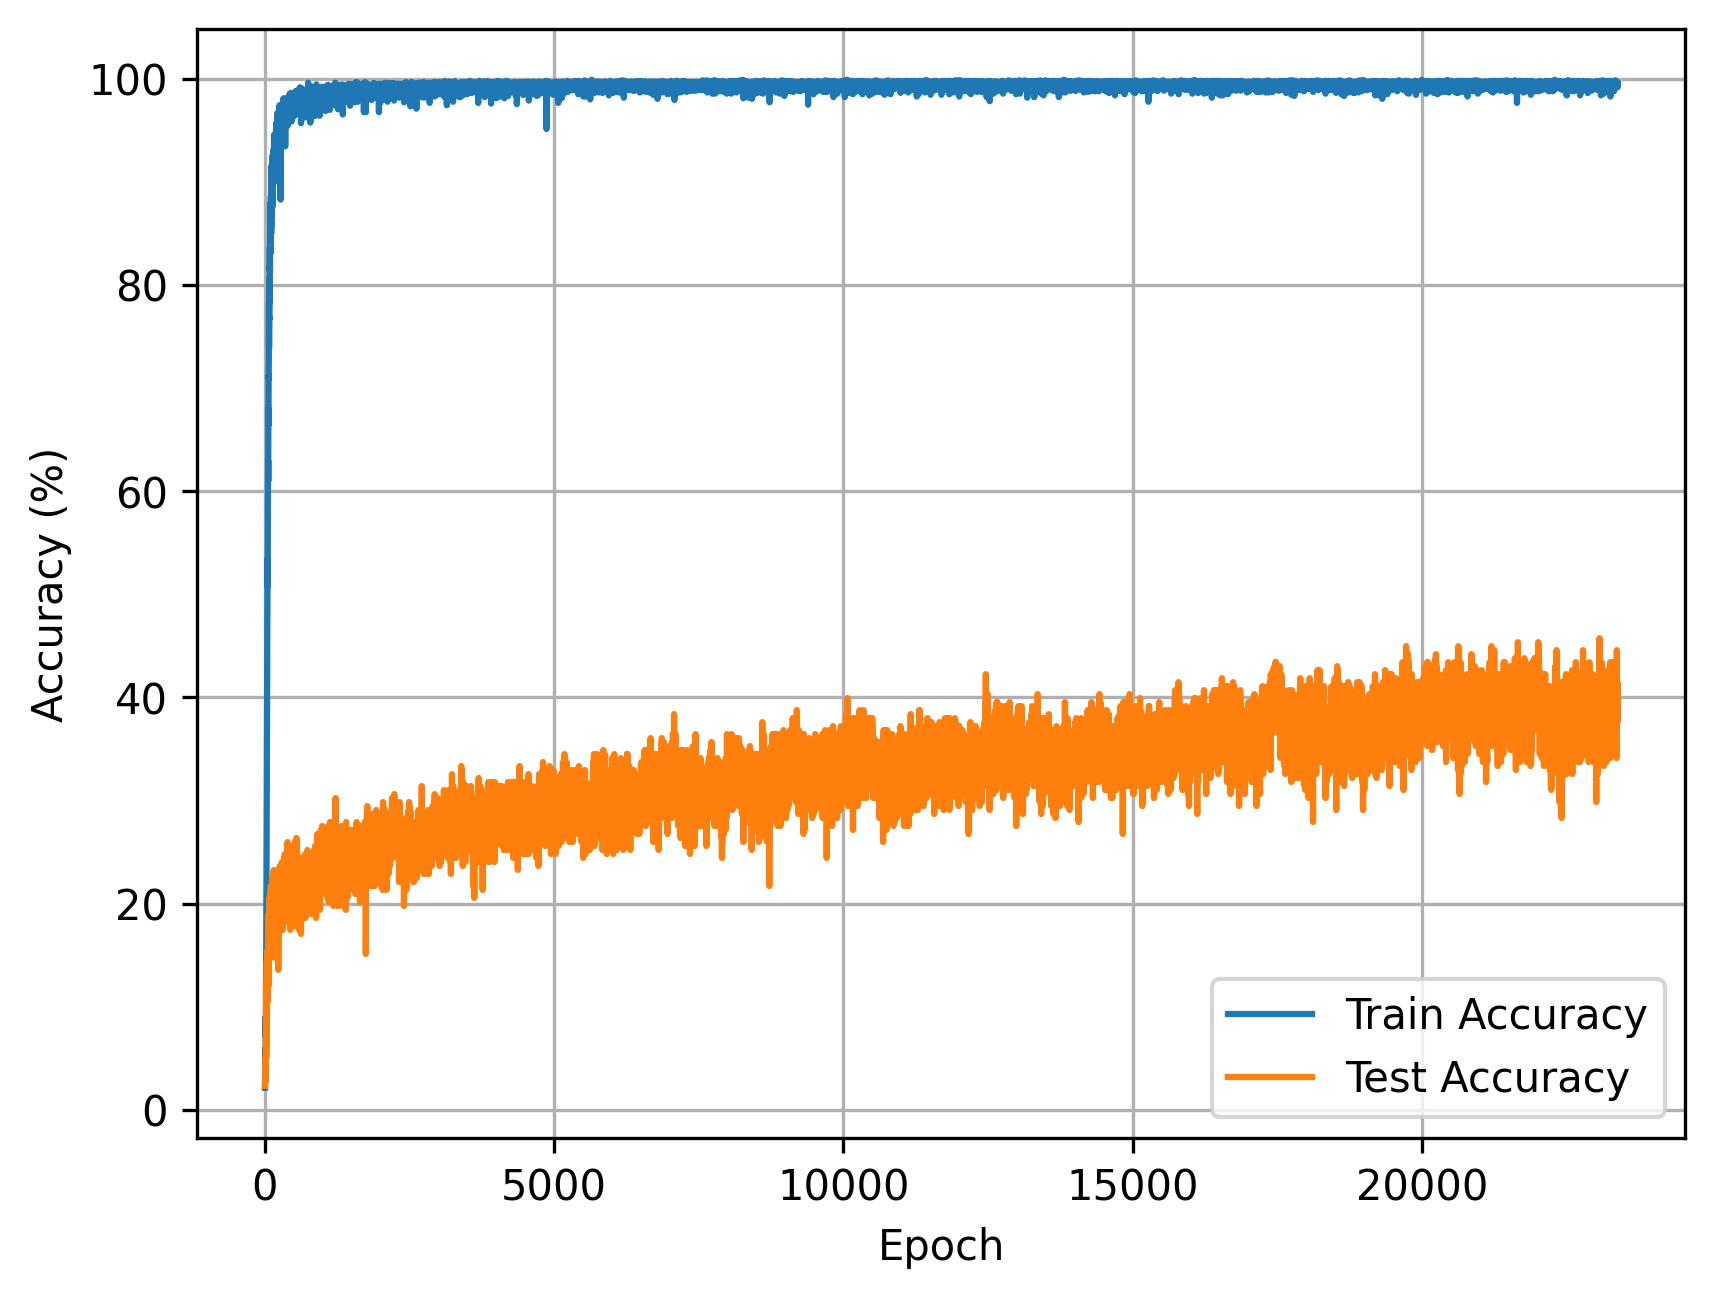

In [27]:
end_epoch=len(test_acc)
epochs = np.arange(end_epoch)
print(f"train_len={len(train_acc)}, val_len={len(val_acc)}, test_len={len(test_acc)}")

plt.figure(dpi=300)
plt.plot(epochs, train_acc[:end_epoch], label="Train Accuracy")
plt.plot(epochs, test_acc[:end_epoch], label="Test Accuracy")

plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.grid()
plt.show()


In [11]:
# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))

# F1 Score (macro/weighted)
print("\nF1 Score (macro):", f1_score(all_labels, all_preds, average='macro'))
print("F1 Score (weighted):", f1_score(all_labels, all_preds, average='weighted'))

# Mean Squared Error
print("\nMean Squared Error (MSE):", mean_squared_error(all_labels, all_preds))

# Full Classification Report (includes precision, recall, F1, support)
print("\nClassification Report:\n", classification_report(all_labels, all_preds))

Confusion Matrix:
[[128770    209    158 ...      6    837   8926]
 [    52  16193     85 ...   3414      9      8]
 [  2904  33327 106246 ...   2185    220      7]
 ...
 [     0   3186     19 ...  64000     84      1]
 [  5205     58     20 ...     41 240719      0]
 [   483      6    148 ...      5      0 200822]]

F1 Score (macro): 0.44337062666707544
F1 Score (weighted): 0.4408556839961041

Mean Squared Error (MSE): 200.71752112171666

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.50      0.61    257385
           1       0.16      0.09      0.12    171590
           2       0.44      0.31      0.36    343180
           3       0.81      0.56      0.67    257385
           4       0.32      0.26      0.29    171590
           5       0.66      0.96      0.78    343180
           6       0.80      0.82      0.81    171590
           7       0.79      0.97      0.87    171590
           8       0.18      0.19      0.18  

In [ ]:
from sklearn.metrics import (
    f1_score,
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    classification_report
)

file_name = "CNN-LSTM-100words-67joints_report.txt"
with open(file_name, 'w') as f:
    # f.write("Confusion Matrix:\n")
    # f.write(str(confusion_matrix(all_labels, all_preds)))
    
    f.write("F1 Score (macro):\n")
    f.write(f"{f1_score(all_labels, all_preds, average='macro'):.4f}\n\n")

    f.write("F1 Score (weighted):\n")
    f.write(f"{f1_score(all_labels, all_preds, average='weighted'):.4f}\n\n")

    f.write("Mean Squared Error (MSE):\n")
    f.write(f"{mean_squared_error(all_labels, all_preds):.4f}\n\n")

    f.write("Mean Absolute Error (MAE):\n")
    f.write(f"{mean_absolute_error(all_labels, all_preds):.4f}\n\n")

    f.write("R^2 Score:\n")
    f.write(f"{r2_score(all_labels, all_preds):.4f}\n\n")

    f.write("Classification Report:\n")
    f.write(classification_report(all_labels, all_preds))

# Save accuracy trends
df_acc = pd.DataFrame({
    "Epoch": np.arange(len(train_acc)),
    "Train Accuracy": train_acc,
    "Test Accuracy": test_acc
})
df_acc.to_csv("CNN-LSTM-100words-67joints-accuracy.csv", index=False)

df_preds = pd.DataFrame({
    "True Label": all_labels,
    "Predicted Label": all_preds
})
df_preds.to_csv("CNN-LSTM-100words-67joints-predictions.csv", index=False)
